GPU:

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Verificar si CUDA está disponible y usar GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)

if torch.cuda.is_available():
    print("Nombre de la tarjeta gráfica:", torch.cuda.get_device_name(0))
    print("Memoria total de la tarjeta gráfica: {:.2f} GB".format(torch.cuda.get_device_properties(0).total_memory / 1e9))
    print("Memoria disponible antes del entrenamiento: {:.2f} GB".format(torch.cuda.memory_reserved(0) / 1e9))
    print("Memoria asignada antes del entrenamiento: {:.2f} GB".format(torch.cuda.memory_allocated(0) / 1e9))


CUDA available: True
Using device: cuda
Nombre de la tarjeta gráfica: NVIDIA GeForce RTX 3070
Memoria total de la tarjeta gráfica: 8.59 GB
Memoria disponible antes del entrenamiento: 0.07 GB
Memoria asignada antes del entrenamiento: 0.03 GB


Transformaciones:

In [16]:
# Definir transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Definir el mapeo explícito de clases
class_to_idx = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,
    'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15,
    'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23,
    'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28
}

# Cargar conjuntos de datos
train_dataset = datasets.ImageFolder(root='datasets/ASL_Alphabet_Dataset/asl_alphabet_train', transform=transform)
train_dataset.class_to_idx = class_to_idx
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

test_dataset = datasets.ImageFolder(root='datasets/test', transform=transform)
test_dataset.class_to_idx = class_to_idx
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


Definir el modelo:

In [17]:
# Definir el modelo
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN().to(device)

Perdida y el optimizaador

In [18]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Función de entrenamiento

In [19]:
# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Poner a cero los gradientes del optimizador
                optimizer.zero_grad()
                
                # Forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # Actualizar estadísticas
                running_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})
                pbar.update(1)
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        if torch.cuda.is_available():
            print("Memoria asignada durante el entrenamiento: {:.2f} GB".format(torch.cuda.memory_allocated(0) / 1e9))
            print("Memoria reservada durante el entrenamiento: {:.2f} GB".format(torch.cuda.memory_reserved(0) / 1e9))
            torch.cuda.empty_cache()  # Liberar memoria no utilizada

Función de evaluación

In [20]:
# Evaluar el modelo
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

MAIN:

In [21]:

# Entrenar el modelo
train_model(model, train_loader, criterion, optimizer, num_epochs=15)
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'ASL2_language_model.pth')
# Evaluar el modelo
evaluate_model(model, test_loader)
# Ver resumen de la memoria
if torch.cuda.is_available():
    print(torch.cuda.memory_summary(device=None, abbreviated=False))


Epoch 1/15: 100%|██████████| 3379/3379 [09:13<00:00,  6.11batch/s, loss=0.238]


Epoch [1/15], Loss: 0.9074
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 2/15: 100%|██████████| 3379/3379 [02:21<00:00, 23.82batch/s, loss=0.316] 


Epoch [2/15], Loss: 0.3158
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 3/15: 100%|██████████| 3379/3379 [02:20<00:00, 24.12batch/s, loss=0.169] 


Epoch [3/15], Loss: 0.2158
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 4/15: 100%|██████████| 3379/3379 [02:20<00:00, 24.05batch/s, loss=0.144] 


Epoch [4/15], Loss: 0.1679
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 5/15: 100%|██████████| 3379/3379 [02:19<00:00, 24.31batch/s, loss=0.108]  


Epoch [5/15], Loss: 0.1395
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 6/15: 100%|██████████| 3379/3379 [02:18<00:00, 24.42batch/s, loss=0.0207] 


Epoch [6/15], Loss: 0.1195
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 7/15: 100%|██████████| 3379/3379 [02:19<00:00, 24.15batch/s, loss=0.0483] 


Epoch [7/15], Loss: 0.1075
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 8/15: 100%|██████████| 3379/3379 [02:23<00:00, 23.62batch/s, loss=0.173]   


Epoch [8/15], Loss: 0.0957
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 9/15: 100%|██████████| 3379/3379 [02:18<00:00, 24.31batch/s, loss=0.173]  


Epoch [9/15], Loss: 0.0895
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 10/15: 100%|██████████| 3379/3379 [02:17<00:00, 24.51batch/s, loss=0.101]   


Epoch [10/15], Loss: 0.0822
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 11/15: 100%|██████████| 3379/3379 [02:19<00:00, 24.21batch/s, loss=0.037]   


Epoch [11/15], Loss: 0.0754
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 12/15: 100%|██████████| 3379/3379 [02:19<00:00, 24.20batch/s, loss=0.159]   


Epoch [12/15], Loss: 0.0710
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 13/15: 100%|██████████| 3379/3379 [02:19<00:00, 24.28batch/s, loss=0.0664]  


Epoch [13/15], Loss: 0.0673
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 14/15: 100%|██████████| 3379/3379 [02:18<00:00, 24.41batch/s, loss=0.00443] 


Epoch [14/15], Loss: 0.0640
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB


Epoch 15/15: 100%|██████████| 3379/3379 [02:18<00:00, 24.41batch/s, loss=0.00446] 


Epoch [15/15], Loss: 0.0596
Memoria asignada durante el entrenamiento: 0.03 GB
Memoria reservada durante el entrenamiento: 0.07 GB
Accuracy: 4.76%
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  31316 KiB |  53405 KiB |   3079 GiB |   3079 GiB |
|       from large pool |  29984 KiB |  51480 KiB |   2954 GiB |   2954 GiB |
|       from small pool |   1332 KiB |   3453 KiB |    125 GiB |    125 GiB |
|------------------------------------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


TEST ACCURACY = 92.85714285714286%


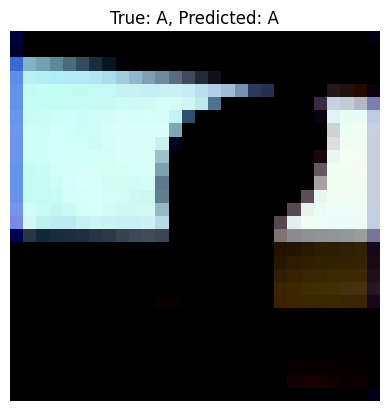

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.48235297].


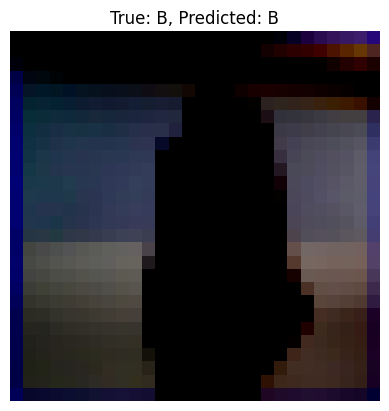

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.5372549].


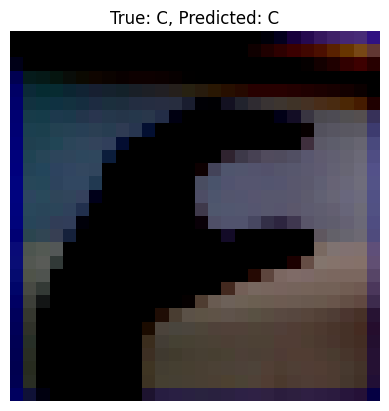

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.56078434].


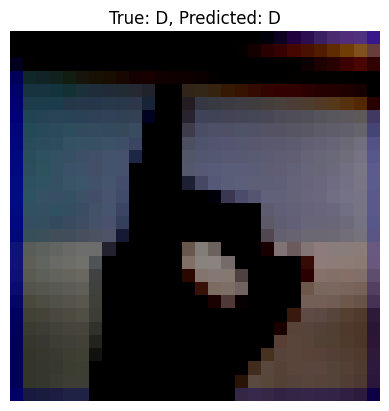

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.5058824].


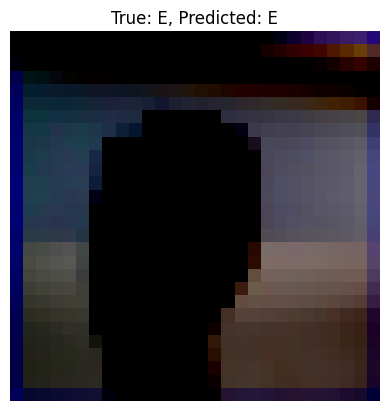

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.41960788].


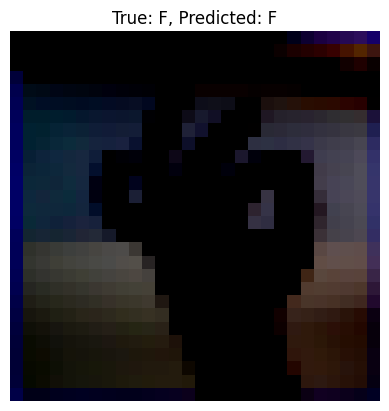

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.36470592].


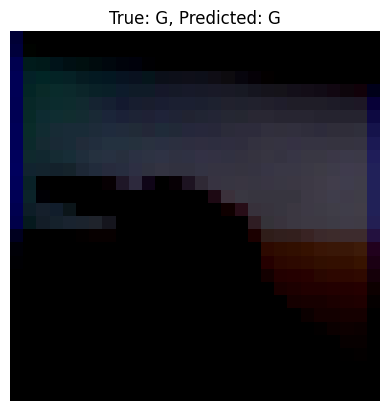

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.4901961].


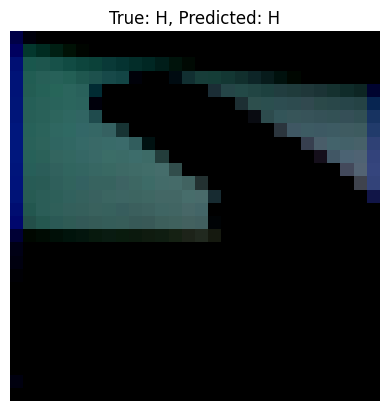

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.6].


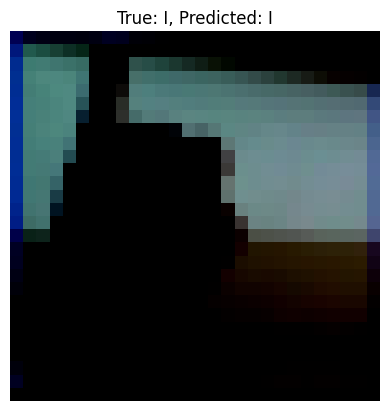

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..0.54509807].


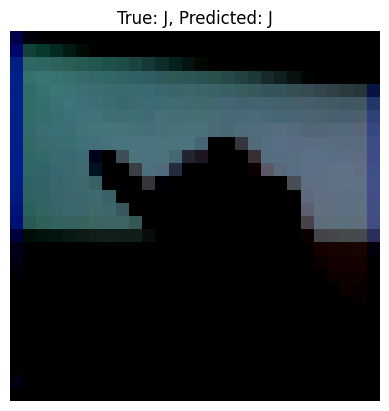

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.5529412].


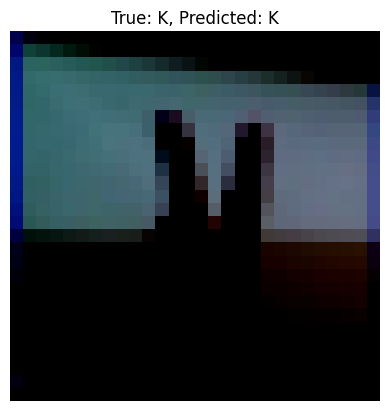

In [24]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Mapeo de nombres de archivos a etiquetas
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

# Directorio de imágenes de prueba
test_dir = 'datasets/ASL_Alphabet_Dataset/asl_alphabet_test'

# Definir el modelo original
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cargar el modelo guardado
model = CNN()
model.load_state_dict(torch.load('ASL2_language_model.pth'))
model.eval()

# Procesar y cargar imágenes de prueba manualmente
test_images = []
test_labels = []

for class_name in class_names:
    image_path = os.path.join(test_dir, f"{class_name}_test.jpg")
    if os.path.exists(image_path):
        img = Image.open(image_path).convert('RGB')
        img = transform(img)
        test_images.append(img)
        test_labels.append(class_names.index(class_name))

# Convertir listas a tensores de PyTorch
test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

# Convertir etiquetas a one-hot encoding con 29 clases
test_labels_one_hot = torch.eye(29)[test_labels]

# Evaluación del modelo en el conjunto de prueba
with torch.no_grad():
    outputs = model(test_images)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(outputs, test_labels)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == test_labels).sum().item() / len(test_labels)

print('TEST ACCURACY = {}%'.format(accuracy * 100))

# Mostrar las imágenes con sus predicciones
for i in range(len(test_images)):
    plt.imshow(test_images[i].permute(1, 2, 0).numpy())
    plt.title(f"True: {class_names[test_labels[i]]}, Predicted: {class_names[predicted[i]]}")
    plt.axis('off')
    plt.show()
    if i == 10:  # Mostrar solo los primeros 10 resultados
        break


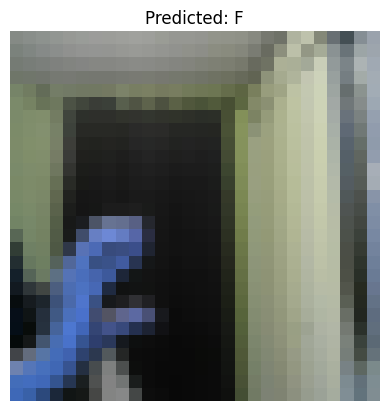

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Definir el modelo
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 29)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Cargar el modelo guardado
model = CNN()
model.load_state_dict(torch.load('ASL2_language_model.pth'))
model.eval()

# Definir transformaciones para las imágenes de prueba
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Mapeo de nombres de archivos a etiquetas
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

def capture_image():
    # Capturar imagen desde la cámara
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: No se puede abrir la cámara.")
        return None
    
    ret, frame = cap.read()
    if not ret:
        print("Error: No se puede leer la imagen de la cámara.")
        cap.release()
        return None

    # Guardar la imagen capturada temporalmente
    image_path = 'captured_image.png'
    cv2.imwrite(image_path, frame)

    # Liberar la cámara
    cap.release()
    cv2.destroyAllWindows()
    return image_path

def preprocess_image(image_path, target_size=(28, 28)):
    # Cargar y procesar la imagen
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Añadir dimensión para el lote
    return img

def predict_image_from_camera():
    # Capturar la imagen
    image_path = capture_image()
    if image_path is None:
        return

    # Preprocesar la imagen capturada
    img_tensor = preprocess_image(image_path, target_size=(28, 28))
    
    # Realizar predicción
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs, 1)
        predicted_label = class_names[predicted_class.item()]

    # Mostrar la imagen preprocesada con la predicción
    plt.imshow(img_tensor[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Des-normalizar la imagen
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Llamar a la función para predecir la imagen de la cámara
predict_image_from_camera()
